In [1]:
import argparse
import cv2
import json
import linecache
import numpy as np
import os
import pandas as pd
import pycocotools.mask as mask_util
from imantics import Mask
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
import shutil

# 单个杯子的目标定位

In [2]:
def create_bounding_box(array):
    nonzero_indices = np.nonzero(array)
    min_row = np.min(nonzero_indices[0])
    min_col = np.min(nonzero_indices[1])
    max_row = np.max(nonzero_indices[0])
    max_col = np.max(nonzero_indices[1])
    return min_col, min_row, max_col, max_row

In [2]:
image = cv2.imread('./obj/mug_01_00003.png', cv2.IMREAD_GRAYSCALE)

with open('./obj-label/mug_01_00003.json', encoding='utf-8') as a:
    result = json.load(a)
    
rle_obj = {'counts': result['labels'][0]['mask'], 'size': [640, 640]}
mask = mask_util.decode(rle_obj)
mask_box = create_bounding_box(mask)

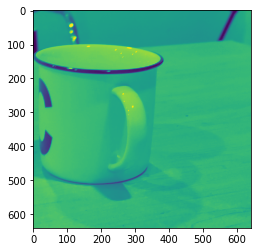

In [3]:
plt.imshow(image)

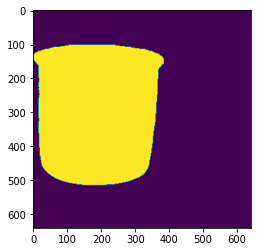

In [4]:
plt.imshow(mask)

# 多个杯子场景中的目标定位

## 预训练模型的标注框

In [3]:
def create_box(array):
    box_num = len(array) // 4
    box_list = [array[x * 4:x * 4 + 4] for x in range(box_num)]
    return box_list

In [134]:
scene_id_list = [1, 2, 3, 4, 6, 7, 9, 10, 20, 22, 23, 24, 25, 27, 38, 39, 40, 41, 42, 43]
scene_id_list_plus = [5, 30, 45, 46, 47]
scene_id = scene_id_list[0]

wrong_list = pd.read_csv('box_wrongnew/wrong%d.txt' % scene_id, delimiter=' ', header=None).T.to_numpy()[0]
right_list = np.array([x for x in range(100) if x not in wrong_list])
label_list = pd.read_csv('box_wrongnew/label%d.txt' % scene_id, delimiter=' ', header=None).to_numpy()
lines = [linecache.getline('box_wrongnew/box%d.txt' % scene_id, idx + 1) for idx in right_list]
box_data = pd.DataFrame([line.split() for line in lines]).to_numpy().astype(float)

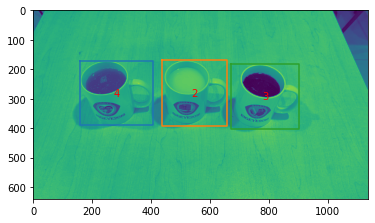

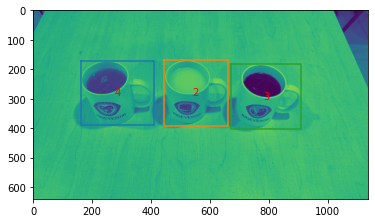

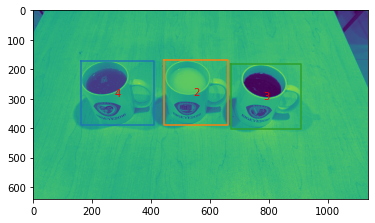

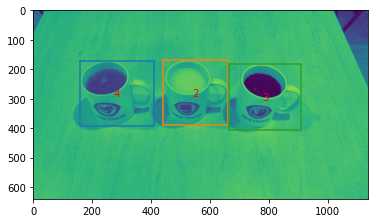

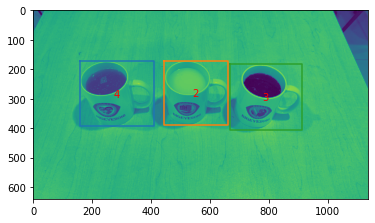

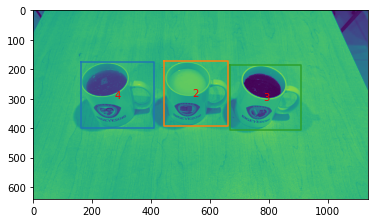

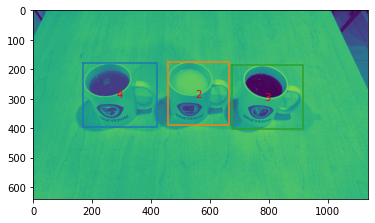

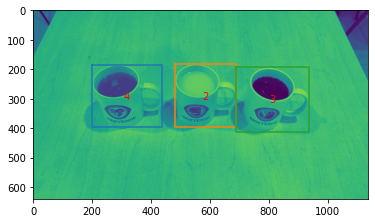

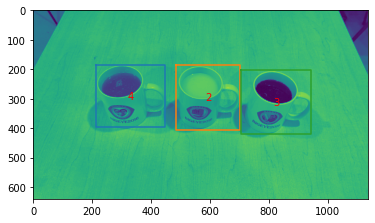

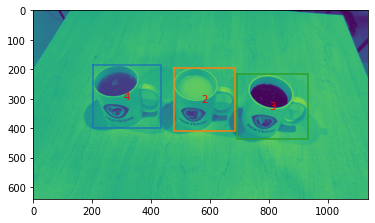

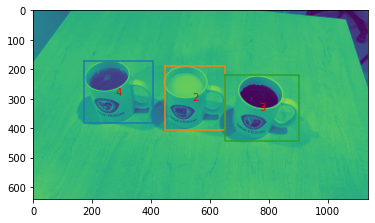

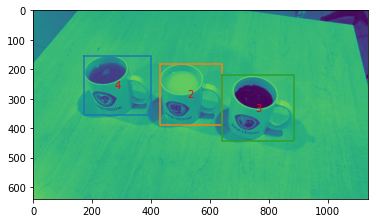

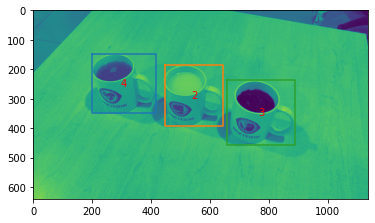

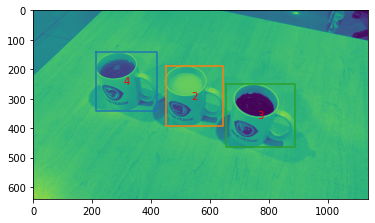

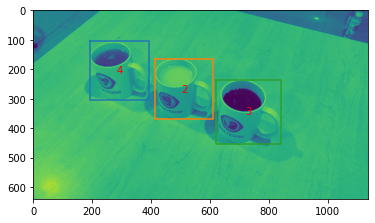

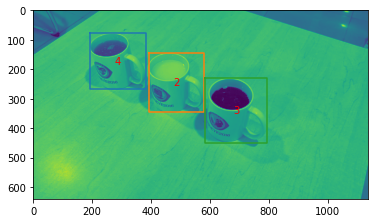

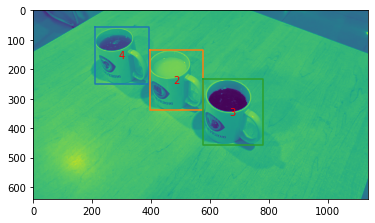

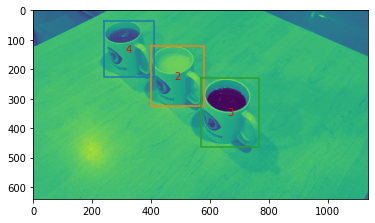

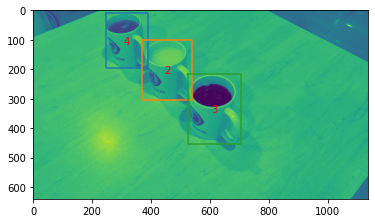

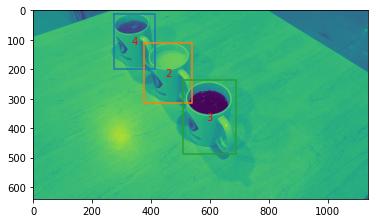

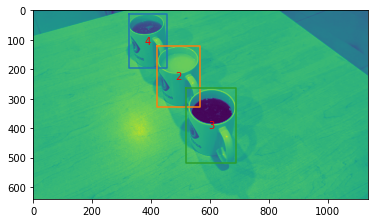

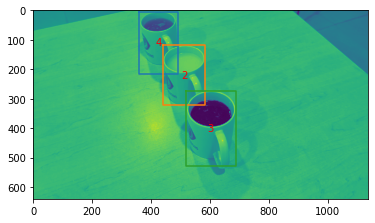

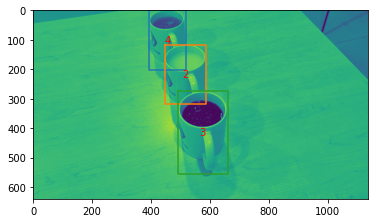

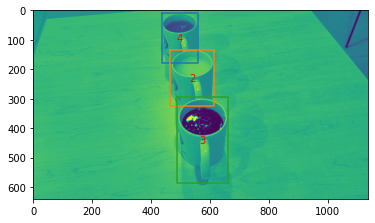

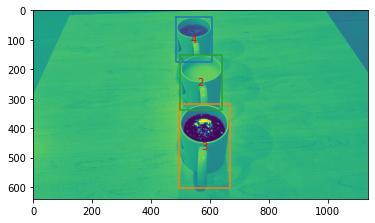

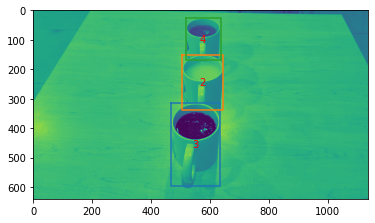

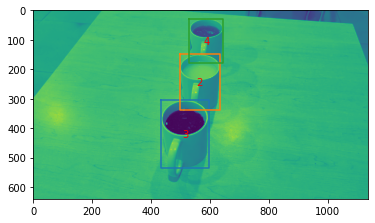

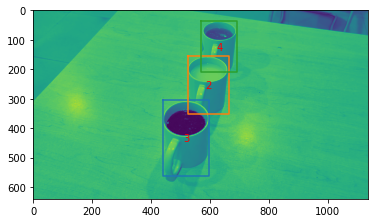

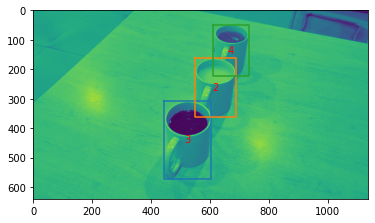

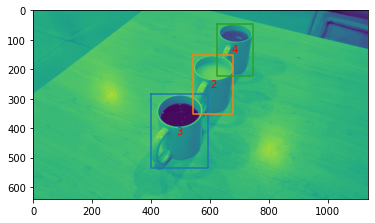

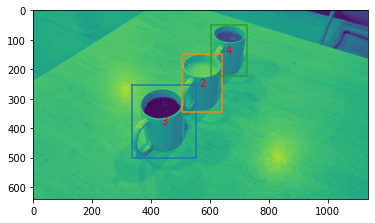

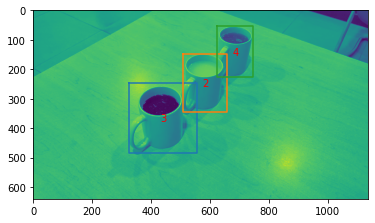

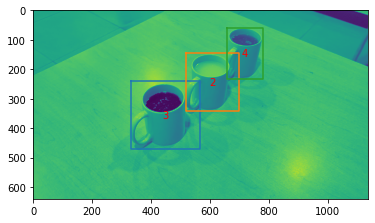

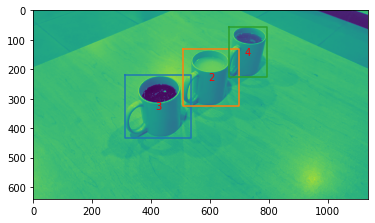

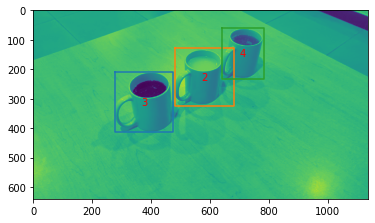

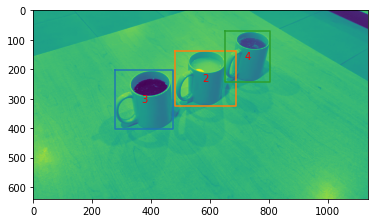

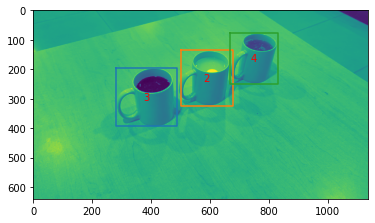

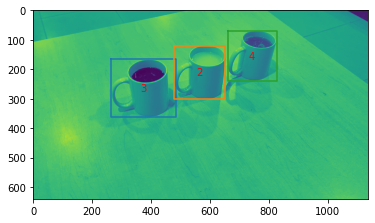

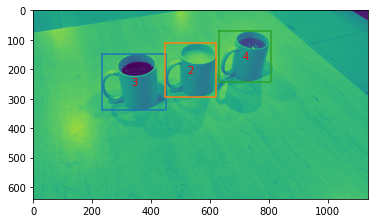

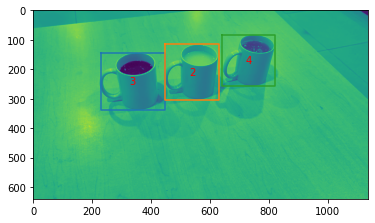

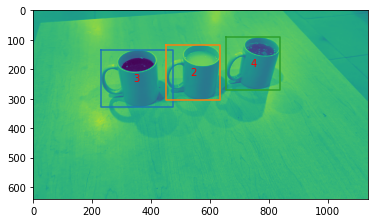

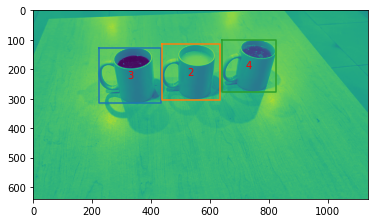

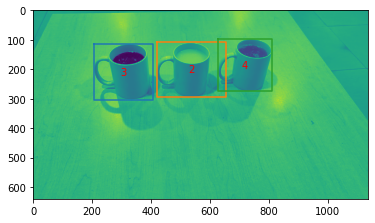

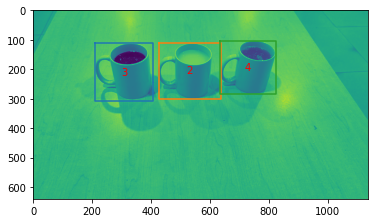

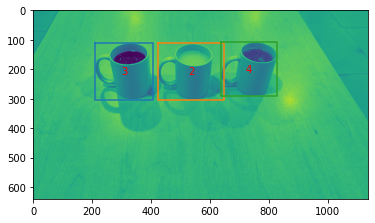

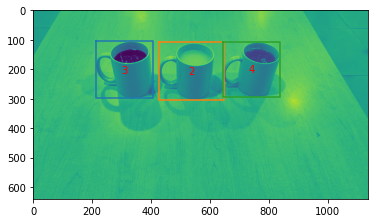

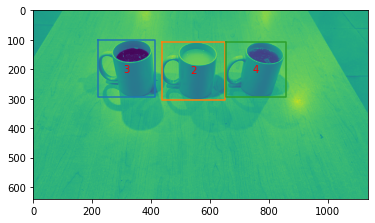

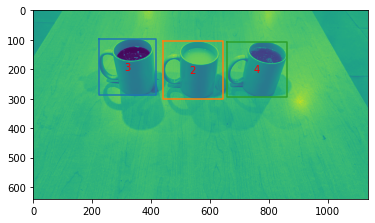

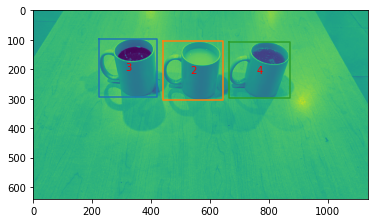


KeyboardInterrupt



In [7]:
for i in range(len(box_data)):
    box_list = create_box(box_data[i])
    img_id = right_list[i]
    labels = label_list[img_id]
    image = cv2.imread('./scene/scene_' + str(scene_id).zfill(2) + '_' + str(img_id).zfill(5) + '.png', cv2.IMREAD_GRAYSCALE)
    plt.imshow(image)
    for j, box in enumerate(box_list):
        plt.plot([box[0], box[0], box[2], box[2], box[0]], [box[1], box[3], box[3], box[1], box[1]])
        plt.text((box[0] + box[2]) / 2, (box[1] + box[3]) / 2, str(labels[j]), c='red', ha='center', va='center')
    plt.show()

标签数据批次处理

In [8]:
scene_id_list = [1, 2, 3, 4, 6, 7, 9, 10, 20, 22, 23, 24, 25, 27, 38, 39, 40, 41, 42, 43]
scene_id_list_plus = [5, 30, 45, 46, 47]
for scene_id in tqdm(scene_id_list):
    if scene_id == 30:
        right_list = np.arange(100)
    else:
        wrong_list = pd.read_csv('box_wrongnew/wrong%d.txt' % scene_id, delimiter=' ', header=None).T.to_numpy()[0]
        right_list = np.array([x for x in range(100) if x not in wrong_list])
    label_list = pd.read_csv('box_wrongnew/label%d.txt' % scene_id, delimiter=' ', header=None).to_numpy()
    lines = [linecache.getline('box_wrongnew/box%d.txt' % scene_id, idx + 1) for idx in right_list]
    box_data = pd.DataFrame([line.split() for line in lines]).to_numpy().astype(float)

    for i in range(len(box_data)):
        box_list = create_box(box_data[i])
        img_id = right_list[i]
        labels = label_list[img_id]
        output = []
        output_path = './scene_label_yolo/scene_' + str(scene_id).zfill(2) + '_' + str(img_id).zfill(5) + '.txt'
        for j, box in enumerate(box_list):
            output.append([labels[j] - 1, 
                           (box[0] + box[2]) / 2 / image.shape[1], (box[1] + box[3]) / 2 / image.shape[0],
                           (box[2] - box[0]) / image.shape[1], (box[3] - box[1]) / image.shape[0]])
        output = pd.DataFrame(output).sort_values(0)
        output.to_csv(output_path, index=False, header=False, sep=' ')

  0%|          | 0/1 [00:00<?, ?it/s]

In [150]:
for path in os.listdir('scene_label_yolo'):
    name = path[:-4] + '.png'
    shutil.copy2('scene/' + name, 'scene_yolo/' + name)

## 手动标注的解码与标注框构造

In [152]:
scene_id_list = [1, 2, 3, 4, 6, 7, 9, 10, 20, 22, 23, 24, 25, 27, 38, 39, 40, 41, 42, 43]
scene_id = scene_id_list[0]

In [222]:
box_path = './scene_label/' + str(scene_id) + '/'
for box_json in os.listdir(box_path)[:1]:
    print(box_json)
    with open(box_path + box_json, encoding='utf-8') as a:
        box_data = json.load(a)

scene_01_00001.json


In [223]:
labels = []
box_list = []
for i in range(len(box_data['labels'])):
    label = int(box_data['labels'][i]['name'])
    labels.append(label)
    rle_obj = {'counts': box_data['labels'][i]['mask'], 'size': [640, 1137]}
    mask = mask_util.decode(rle_obj)
    mask_box = create_bounding_box(mask)
    box_list.append(mask_box)

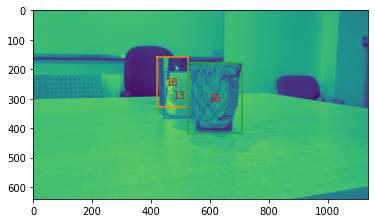

In [4]:
img_path = './scene/' + box_json[:-4] + 'png'
image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
plt.imshow(image)
for j, box in enumerate(box_list):
    plt.plot([box[0], box[0], box[2], box[2], box[0]], [box[1], box[3], box[3], box[1], box[1]])
    plt.text((box[0] + box[2]) / 2, (box[1] + box[3]) / 2, str(labels[j]), c='red', ha='center', va='center')
plt.show()

标签数据批次处理

In [9]:
scene_id_list = [1, 2, 3, 4, 5, 6, 7, 9, 10, 20, 22, 23, 24, 25, 27, 38, 39, 40, 41, 42, 43, 46, 47]
scene_id_list = [45]
for scene_id in tqdm(scene_id_list):
    box_path = './scene_label/' + str(scene_id) + '/'
    for box_json in os.listdir(box_path):
        with open(box_path + box_json, encoding='utf-8') as a:
            box_data = json.load(a)
        labels = []
        box_list = []
        for i in range(len(box_data['labels'])):
            label = int(box_data['labels'][i]['name'])
            labels.append(label)
            rle_obj = {'counts': box_data['labels'][i]['mask'], 'size': [640, 1137]}
            mask = mask_util.decode(rle_obj)
            mask_box = create_bounding_box(mask)
            box_list.append(mask_box)
        output = []
        output_path = ('./scene_label_man/' + box_json[:-4] + 'txt')
        for j, box in enumerate(box_list):
            output.append([labels[j] - 1, 
                           (box[0] + box[2]) / 2 / image.shape[1], (box[1] + box[3]) / 2 / image.shape[0],
                           (box[2] - box[0]) / image.shape[1], (box[3] - box[1]) / image.shape[0]])
        output = pd.DataFrame(output).sort_values(0)
        output.to_csv(output_path, index=False, header=False, sep=' ')

  0%|          | 0/1 [00:00<?, ?it/s]

In [227]:
for path in os.listdir('scene_label_man'):
    name = path[:-4] + '.png'
    shutil.copy2('scene/' + name, 'scene_man/' + name)

## 单个杯子

In [4]:
box_path = './obj_label/'
for box_json in os.listdir(box_path):
    with open(box_path + box_json, encoding='utf-8') as a:
        box_data = json.load(a)
    labels = []
    box_list = []
    for i in range(len(box_data['labels'])):
        label = int(box_data['labels'][i]['name'])
        labels.append(label)
        rle_obj = {'counts': box_data['labels'][i]['mask'], 'size': [640, 640]}
        mask = mask_util.decode(rle_obj)
        mask_box = create_bounding_box(mask)
        box_list.append(mask_box)
    output = []
    output_path = ('./obj_label_all/' + box_json[:-4] + 'txt')
    for j, box in enumerate(box_list):
        output.append([labels[j] - 1, 
                       (box[0] + box[2]) / 2 / 640, (box[1] + box[3]) / 2 / 640,
                       (box[2] - box[0]) / 640, (box[3] - box[1]) / 640])
    output = pd.DataFrame(output).sort_values(0)
    output.to_csv(output_path, index=False, header=False, sep=' ')